## This script checks the length of the audio and EEG.

### Trial length from audio is not constant, and it is normally shorter than that of the EEG trigger, as well as that of matlab log. Lengths obtained from the EEG trigger and matlab log are relatively the same.


There is a [1 0 1 0 1 0] marker at the begining of the trials.

Session 3: audio: 848.1779583333333s;

In [1]:
from speech_pinyin.config import *
import glob
from scipy.io import wavfile
import matplotlib.pylab as plt
import mne
import numpy as np
from utils.util_MNE import keep_annotation
import itertools

2024-09-03 13:31:47 - Start Program

pre_all: Running from CMD.
common_dl.py: Using CUDA.


In [2]:
sid=1
folder=data_dir+str(sid)+'-*'
folder=os.path.normpath(glob.glob(folder)[0])
folder=folder.replace("\\", "/")
audio_folder=folder+'/raw/matlab/result/'
files=['name_202408280901','name_202408280930','name_202408280959']

### change session value and loop below cells for all three sessions.

In [3]:
session=3
file=audio_folder+files[session-1]+'/recording.wav'
sf_audio,audio=wavfile.read(file)

C:\Users\xiaowu\AppData\Local\Temp\ipykernel_77520\2686718653.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf_audio,audio=wavfile.read(file)


In [4]:
len(audio)/48000

848.1779583333333

In [5]:
trial_begins=[]
beep=[1,0,1,0,1,0]
index=0
while index<len(audio)-10:
    if all(audio[index:index+6]==beep):
        trial_begins.append(index+6)
        index=index+5*48000 # jump before step-by-step search
    index=index+1
print(len(trial_begins))

144


In [6]:
# remove the beep
audio_clean=[]
lengths=[]
for i in range(len(trial_begins)):
    if i==len(trial_begins)-1:
        trial_start=trial_begins[i]
        tmp=audio[trial_start:]
    else:
        trial_start=trial_begins[i]
        trial_stop=trial_begins[i+1]-6
        tmp=audio[trial_start:trial_stop]
    length=len(tmp)
    lengths.append(length/48000)
    audio_clean.append(tmp)
print(len(audio_clean))

144


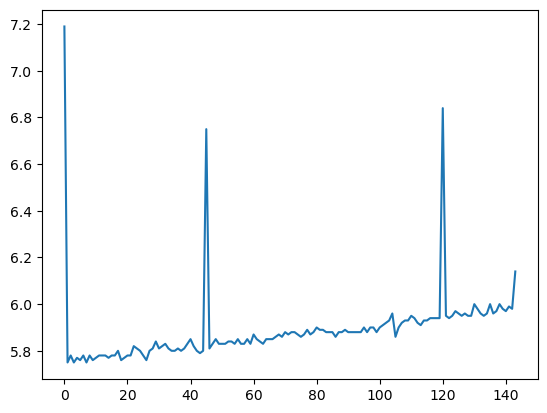

In [7]:
# save trial length
plt.plot(lengths)
filename=folder+'/processed/session'+str(session)+'_trial_length_audio'
np.save(filename, np.array(lengths, dtype=object), allow_pickle=True)

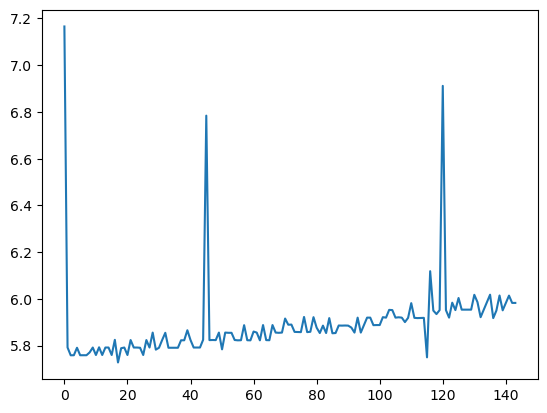

In [8]:
lengths2=np.load(folder+'/processed/session3'+'_trial_length_EEG.npy', allow_pickle=True) # 144
plt.plot(lengths2)

In [9]:
import hdf5storage

filename=folder+'/raw/matlab/result/name_202408280959/prompt_shown.mat'
mat=hdf5storage.loadmat(filename)
prompt_shown=mat['prompt_shown'][0]
prompt_shown[5] 

#  audio start/end time from matlab correspond to event '10' in EEG:
# matlab:  ['2024-08-28 09:36:46:456@audio_started'] --> ['2024-08-28 09:59:26:176@stop_audio']
# EEG: ('onset', 3794.735107) --> ('onset', 5154.441895) {orig_time: datetime.datetime(2024, 8, 28, 8, 33, 34, tzinfo=datetime.timezone.utc)}
# calculate the absolute time by add 'onset' to the orig_time and get the absolute time of EEG:
# EEG: 09:36:48:735107-->09:59:28:441895
# The difference between the first '10' and the first 'audio_started' is about the same as the difference between the last '10' and the last 'stop_audio';

array(['2024-08-28 09:36:46:456@audio_started'], dtype='<U37')

In [10]:
# calculate audio length using matlab log
length_matlab_log=[]
for i in range(len(prompt_shown)-1):
    tmp1=prompt_shown[i][0].split("@")
    prompt1=tmp1[1]
    time1=datetime.strptime(tmp1[0],'%Y-%m-%d %H:%M:%S:%f')
    
    tmp2=prompt_shown[i+1][0].split("@")
    prompt2=tmp2[1]
    time2=datetime.strptime(tmp2[0],'%Y-%m-%d %H:%M:%S:%f')
    
    if (len(prompt1.split(' '))==3 and len(prompt2.split(' '))==3) or (len(prompt1.split(' '))==3 and prompt2 in ['Pause','stop_audio']) :
        duration=(time2-time1).total_seconds()
        length_matlab_log.append(duration)
    

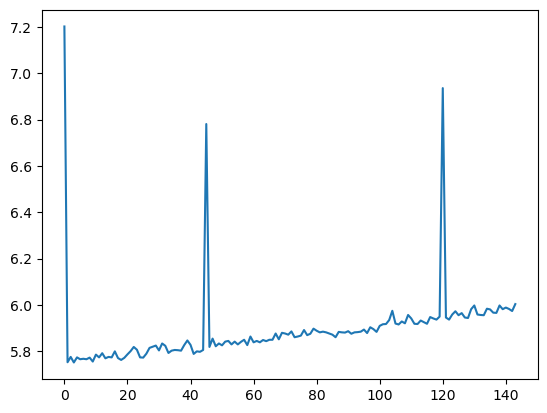

In [11]:
plt.plot(length_matlab_log)

Three very high intervals index: 0, 45, 120, why?? These trials don't correspond to the pausing either. Maybe these is just computer get stucked for few ms.

Another two up-and-down interval is caused by the interpolation of the missing triggers: the length was set to 5.75 which is shorter compared to the real situation.

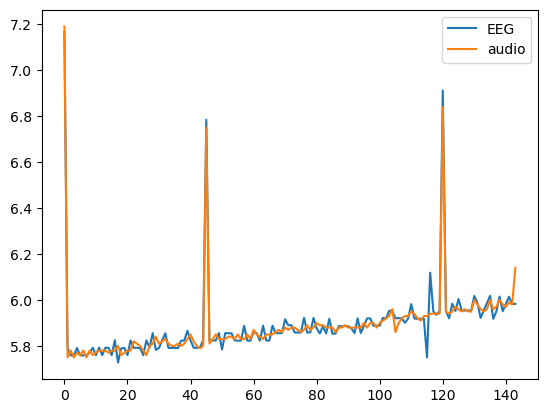

In [12]:
fig,ax=plt.subplots()
ax.plot(lengths2)
ax.plot(lengths)
ax.legend(['EEG','audio'])

In below: 

difference between length obtained by EEG triggers (lengths2) and audio length (lengths) is getting bigger (accum);

difference between length obtained by matlab log (length_matlab_log) and audio length is getting bigger (accum3);

Seems like the Matlab audio capture is missing some samples at each trial.

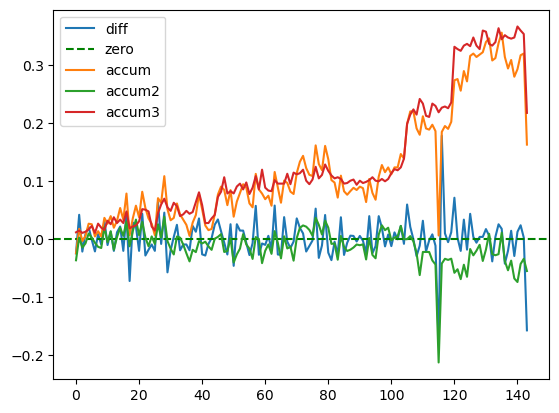

In [13]:
# length difference between recorded audio length (indicated by the [101010] pattern) and the EEG trial length (indicated by the trigger '5');
differences=[lengths2[i]-lengths[i] for i in range(len(lengths2))]
differences2=[lengths2[i]-length_matlab_log[i] for i in range(len(lengths2))]
differences3=[length_matlab_log[i]-lengths[i] for i in range(len(length_matlab_log))]
accum=np.cumsum(differences)# [sum(differences[:i]) for i in range(len(differences))]
accum2=np.cumsum(differences2)#[sum(differences2[:i]) for i in range(len(differences2))]
accum3=np.cumsum(differences3)#[sum(differences3[:i]) for i in range(len(differences3))]
fig,ax=plt.subplots()
ax.plot([lengths2[i]-lengths[i] for i in range(len(lengths2))]) # blue line
ax.axhline(y=0, color='green', linestyle='--')
ax.plot(accum) ## The orange lines shows that the difference between trial length of audio and EEG is gradually increasing, so the misalignment was distributed in all trials. This is not a good news.
ax.plot(accum2)
ax.plot(accum3)
ax.legend(['diff','zero','accum','accum2','accum3'])

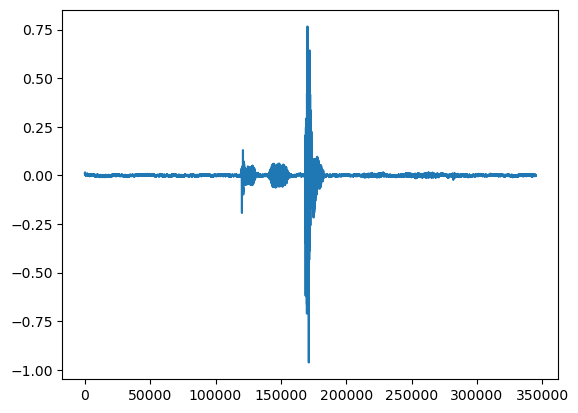

In [82]:
plt.plot(audio_clean[0])